In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import salem

In [6]:
#利用单时刻数据，计算出插值用的 grid信息
out_grid = xe.util.grid_2d(106.875, 117.125, 0.25, 28.875, 38.125, 0.25).rename_dims({'x':'west_east','y':'south_north'})
ds_obs = xr.open_dataset("/mnt/d/work/obs/GPM/3B-DAY-L.MS.MRG.3IMERG.20220724-S000000-E235959.V06.nc4")
regridder_obs = xe.Regridder(ds_obs, out_grid, 'bilinear')

ds_wrf = xr.open_dataset("/mnt/d/work/sunhh/data/run2/1/wrfout_d02_2022-07-25_00_00_00").rename({'XLONG': 'lon', 'XLAT': 'lat'}).isel(Time=0)
regridder_wrf = xe.Regridder(ds_wrf, out_grid, 'bilinear')


In [5]:
ds_wrf

<xarray.Dataset>
Dimensions:                (south_north: 93, west_east: 105, bottom_top: 42,
                            bottom_top_stag: 43, soil_layers_stag: 5,
                            west_east_stag: 106, south_north_stag: 94,
                            seed_dim_stag: 33)
Coordinates:
    lat                    (south_north, west_east) float32 29.42 ... 37.22
    lon                    (south_north, west_east) float32 107.7 ... 117.6
    XTIME                  datetime64[ns] ...
    XLAT_U                 (south_north, west_east_stag) float32 ...
    XLONG_U                (south_north, west_east_stag) float32 ...
    XLAT_V                 (south_north_stag, west_east) float32 ...
    XLONG_V                (south_north_stag, west_east) float32 ...
Dimensions without coordinates: south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/190)
    Times                  |S19 ...
    LU_INDEX               (south_north, west_east) float32 ...
    ZNU                    (bottom_top) float32 ...
    ZNW                    (bottom_top_stag) float32 ...
    ZS                     (soil_layers_stag) float32 ...
    DZS                    (soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (south_north, west_east) float32 ...
    PC                     (south_north, west_east) float32 ...
    LANDMASK               (south_north, west_east) float32 ...
    LAKEMASK               (south_north, west_east) float32 ...
    SST                    (south_north, west_east) float32 ...
    SST_INPUT              (south_north, west_east) float32 ...
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4 MODEL
    START_DATE:                      2022-07-25_00:00:00
    SIMULATION_START_DATE:           2022-07-25_00:00:00
    WEST-EAST_GRID_DIMENSION:        106
    SOUTH-NORTH_GRID_DIMENSION:      94
    BOTTOM-TOP_GRID_DIMENSION:       43
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [7]:
#观测进行插值
obs = []
for day in range(25,27):
    ds_obs = xr.open_dataset(f"/mnt/d/work/obs/GPM/3B-DAY-L.MS.MRG.3IMERG.202207{day}-S000000-E235959.V06.nc4")
    obs_remap = regridder_obs(ds_obs.precipitationCal) 
    obs.append(np.expand_dims(obs_remap[0,], axis=0))
obs = np.concatenate(obs, axis=0)
obs.shape
obs_remap = obs

/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [8]:
#控制试验进行插值
ds_ctl = salem.open_wrf_dataset("/mnt/d/work/sunhh/data/run2/1/wrfout_d02_2022-07-25_00_00_00")
ds_ctl = ds_ctl.RAINC + ds_ctl.RAINNC +ds_ctl.RAINSH
ds_ctl = ds_ctl.loc['2022-07-25T00':'2022-07-27T00':24]
ctl = regridder_wrf(ds_ctl)
ctl.shape
#24小时累计降水
ctl_pre = []
for day in range(25,27):
    pre = ctl.loc[f'2022-07-{day+1}T00'] - ctl.loc[f'2022-07-{day}T00']
    ctl_pre.append(np.expand_dims(pre, axis=0))
ctl_pre = np.concatenate(ctl_pre, axis=0)
ctl_pre.shape
ctl_remap = ctl_pre

/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [9]:
#不同试验的wrfout插值
wrf_remap = []
memlist=["1.1","1.2","1.3"]
for mem in memlist:
    ds_wrf = salem.open_wrf_dataset(f"/mnt/d/work/sunhh/data/run2/{mem}/wrfout_d02_2022-07-25_00_00_00")
    ds_wrf = ds_wrf.RAINC + ds_wrf.RAINNC +ds_wrf.RAINSH
    ds_wrf = ds_wrf.loc['2022-07-25T00':'2022-07-27T00':24]
    wrf = regridder_wrf(ds_wrf)
    wrf_pre = []
    for day in range(25,27):
        pre = wrf.loc[f'2022-07-{day+1}T00'] - wrf.loc[f'2022-07-{day}T00']
        wrf_pre.append(np.expand_dims(pre, axis=0))
    wrf_pre = np.concatenate(wrf_pre, axis=0)
    wrf_remap.append(np.expand_dims(wrf_pre, axis=0))
wrf_remap = np.concatenate(wrf_remap, axis=0)
wrf_remap.shape

/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


(3, 2, 37, 41)

In [10]:
def prep_clf(obs,pre, threshold=0.1):
    '''
    func: 计算二分类结果-混淆矩阵的四个元素
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        hits, misses, falsealarms, correctnegatives
        #aliases: TP, FN, FP, TN 
    '''
    #根据阈值分类为 0, 1
    obs = np.where(obs >= threshold, 1, 0)
    pre = np.where(pre >= threshold, 1, 0)
    # True positive (TP)
    hits = np.sum((obs == 1) & (pre == 1))
    # False negative (FN)
    misses = np.sum((obs == 1) & (pre == 0))
    # False positive (FP)
    falsealarms = np.sum((obs == 0) & (pre == 1))
    # True negative (TN)
    correctnegatives = np.sum((obs == 0) & (pre == 0))
    return hits, misses, falsealarms, correctnegatives
def precision(obs, pre, threshold=0.1):
    '''
    func: 计算精确度precision: TP / (TP + FP)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。   
    returns:
        dtype: float
    '''
    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return TP / (TP + FP)
def recall(obs, pre, threshold=0.1):
    '''
    func: 计算召回率recall: TP / (TP + FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''
    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return TP / (TP + FN)
def ACC(obs, pre, threshold=0.1):
    '''
    func: 计算准确度Accuracy: (TP + TN) / (TP + TN + FP + FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''
    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return (TP + TN) / (TP + TN + FP + FN)
def FSC(obs, pre, threshold=0.1):
    '''
    func:计算f1 score = 2 * ((precision * recall) / (precision + recall))
    '''
    precision_socre = precision(obs, pre, threshold=threshold)
    recall_score = recall(obs, pre, threshold=threshold)
    return 2 * ((precision_socre * recall_score) / (precision_socre + recall_score))

In [11]:
#TS 评分
def TS(obs, pre, threshold=0.1):
    '''
    func: 计算TS评分: TS = hits/(hits + falsealarms + misses) 
    	  alias: TP/(TP+FP+FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''
    hits, misses, falsealarms, correctnegatives = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return hits/(hits + falsealarms + misses) 

In [12]:
TS_ctl = []
for day in range(0,2):
    TS_ctl.append(np.expand_dims(TS(obs_remap, ctl_remap[day,],threshold=1),axis=0))
TS_ctl = np.concatenate(TS_ctl, axis=0)
TS_ctl

array([0.44017279, 0.37610619])

In [13]:
TS_wrfda = []
for mem in range(0,len(memlist)):
    TS_wrfda_temp = []
    for day in range(0,2):
        TS_wrfda_temp.append(np.expand_dims(TS(obs_remap, wrf_remap[mem,day,],threshold=1),axis=0))
    TS_wrfda_temp = np.concatenate(TS_wrfda_temp,axis=0)
    TS_wrfda.append(np.expand_dims(TS_wrfda_temp, axis=0))
TS_wrfda = np.concatenate(TS_wrfda, axis=0)
TS_wrfda 

array([[0.4081359 , 0.33853927],
       [0.41057269, 0.3927161 ],
       [0.37243948, 0.34885845]])

试验1.1 blue
试验1.2 red
试验1.3 green


/tmp/ipykernel_520/3231976025.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("/mnt/d/work/sunhh/figure/run2/1_TS.png",dpi=600, bbox='tight')


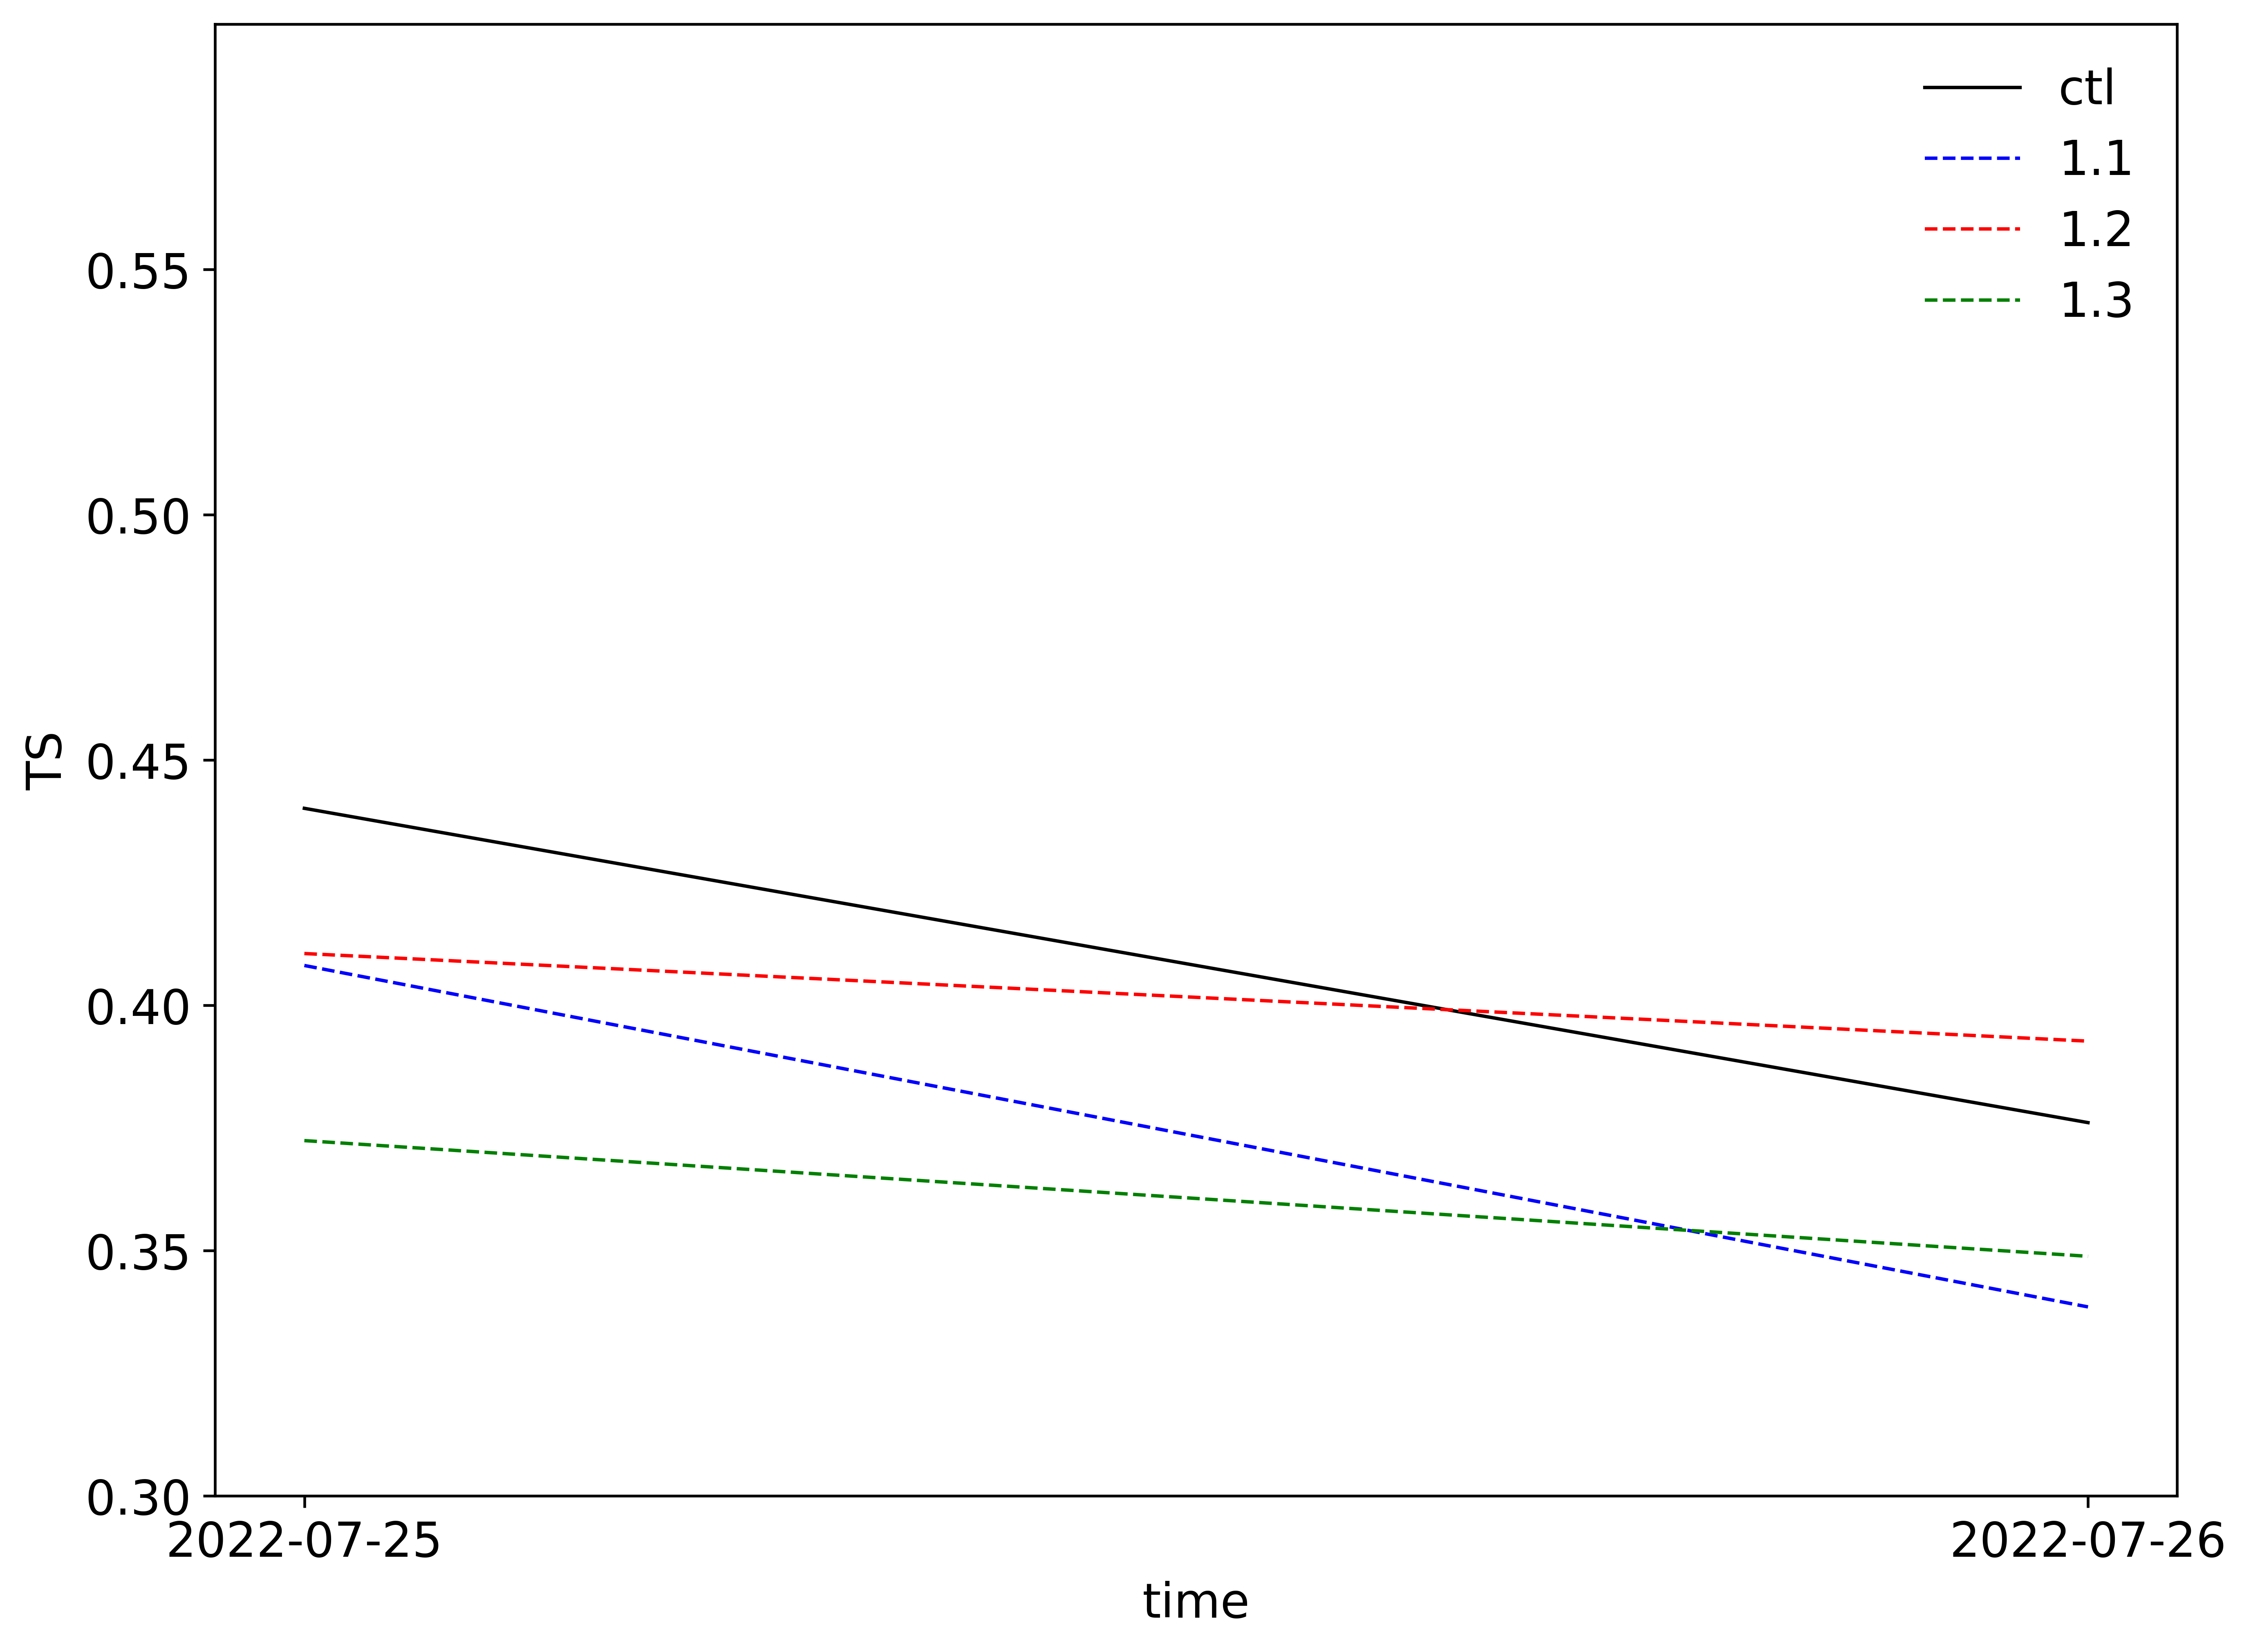

In [15]:
from cProfile import label
import matplotlib.pyplot as plt
import matplotlib as mpl
fig = plt.figure(figsize=[10,10],dpi=600,facecolor='white')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
ax = fig.add_axes([0.1,0.24,0.8,0.6])
ax.plot(np.arange(0,2), TS_ctl, color='black',label='ctl', lw=1, ls='-')
# L = ['blue','red','green', 'purple']
L = ['blue','red','green']
# L=['blue','red']
for mem,cl in enumerate(L):
    print(f'试验{memlist[mem]}',cl)
    ax.plot(np.arange(0,2), TS_wrfda[mem,], color=cl,label=f'{memlist[mem]}', lw=1, ls='--')

plt.xticks(np.arange(0,2),["2022-07-25","2022-07-26"])
ax.set_yticks(np.arange(0.3,0.6,0.05))
ax.set_ylim([0.3,0.6])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylabel('TS',fontsize=14)
ax.set_xlabel('time',fontsize=14)
plt.legend(loc='upper right',fontsize=14,frameon=False)
fig.savefig("/mnt/d/work/sunhh/figure/run2/1_TS.png",dpi=600, bbox='tight')


In [11]:
#不同试验的wrfout插值
wrf_remap = []
memlist=["run1_18-amsua","run1_19-mhs","run1_18-a_19-m"]
for mem in memlist:
    ds_wrf = salem.open_wrf_dataset(f"/mnt/d/work/wrfdir/figure/WRFDA_run1/{mem}/wrfout.nc")
    ds_wrf = ds_wrf.RAINC + ds_wrf.RAINNC +ds_wrf.RAINSH
    ds_wrf = ds_wrf.loc['2022-07-24T00':'2022-07-27T00':8]
    wrf = regridder_wrf(ds_wrf)
    wrf_pre = []
    for day in range(24,27):
        pre = wrf.loc[f'2022-07-{day+1}T00'] - wrf.loc[f'2022-07-{day}T00']
        wrf_pre.append(np.expand_dims(pre, axis=0))
    wrf_pre = np.concatenate(wrf_pre, axis=0)
    wrf_remap.append(np.expand_dims(wrf_pre, axis=0))
wrf_remap = np.concatenate(wrf_remap, axis=0)
wrf_remap.shape

TS_wrfda = []
for mem in range(0,3):
    TS_wrfda_temp = []
    for day in range(0,3):
        TS_wrfda_temp.append(np.expand_dims(TS(obs_remap, wrf_remap[mem,day,],threshold=1),axis=0))
    TS_wrfda_temp = np.concatenate(TS_wrfda_temp,axis=0)
    TS_wrfda.append(np.expand_dims(TS_wrfda_temp, axis=0))
TS_wrfda = np.concatenate(TS_wrfda, axis=0)
TS_wrfda 

/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/mnt/d/work/miniconda/envs/sunhh/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


array([[0.22228454, 0.32318487, 0.3063259 ],
       [0.22528506, 0.30697197, 0.2998326 ],
       [0.22103213, 0.31942393, 0.30694477]])

敏感性试验0 blue
敏感性试验1 purple
敏感性试验2 red


/tmp/ipykernel_529/3451624546.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("/mnt/d/work/sunhh/figure/no19-a_TS.png",dpi=600, bbox='tight')


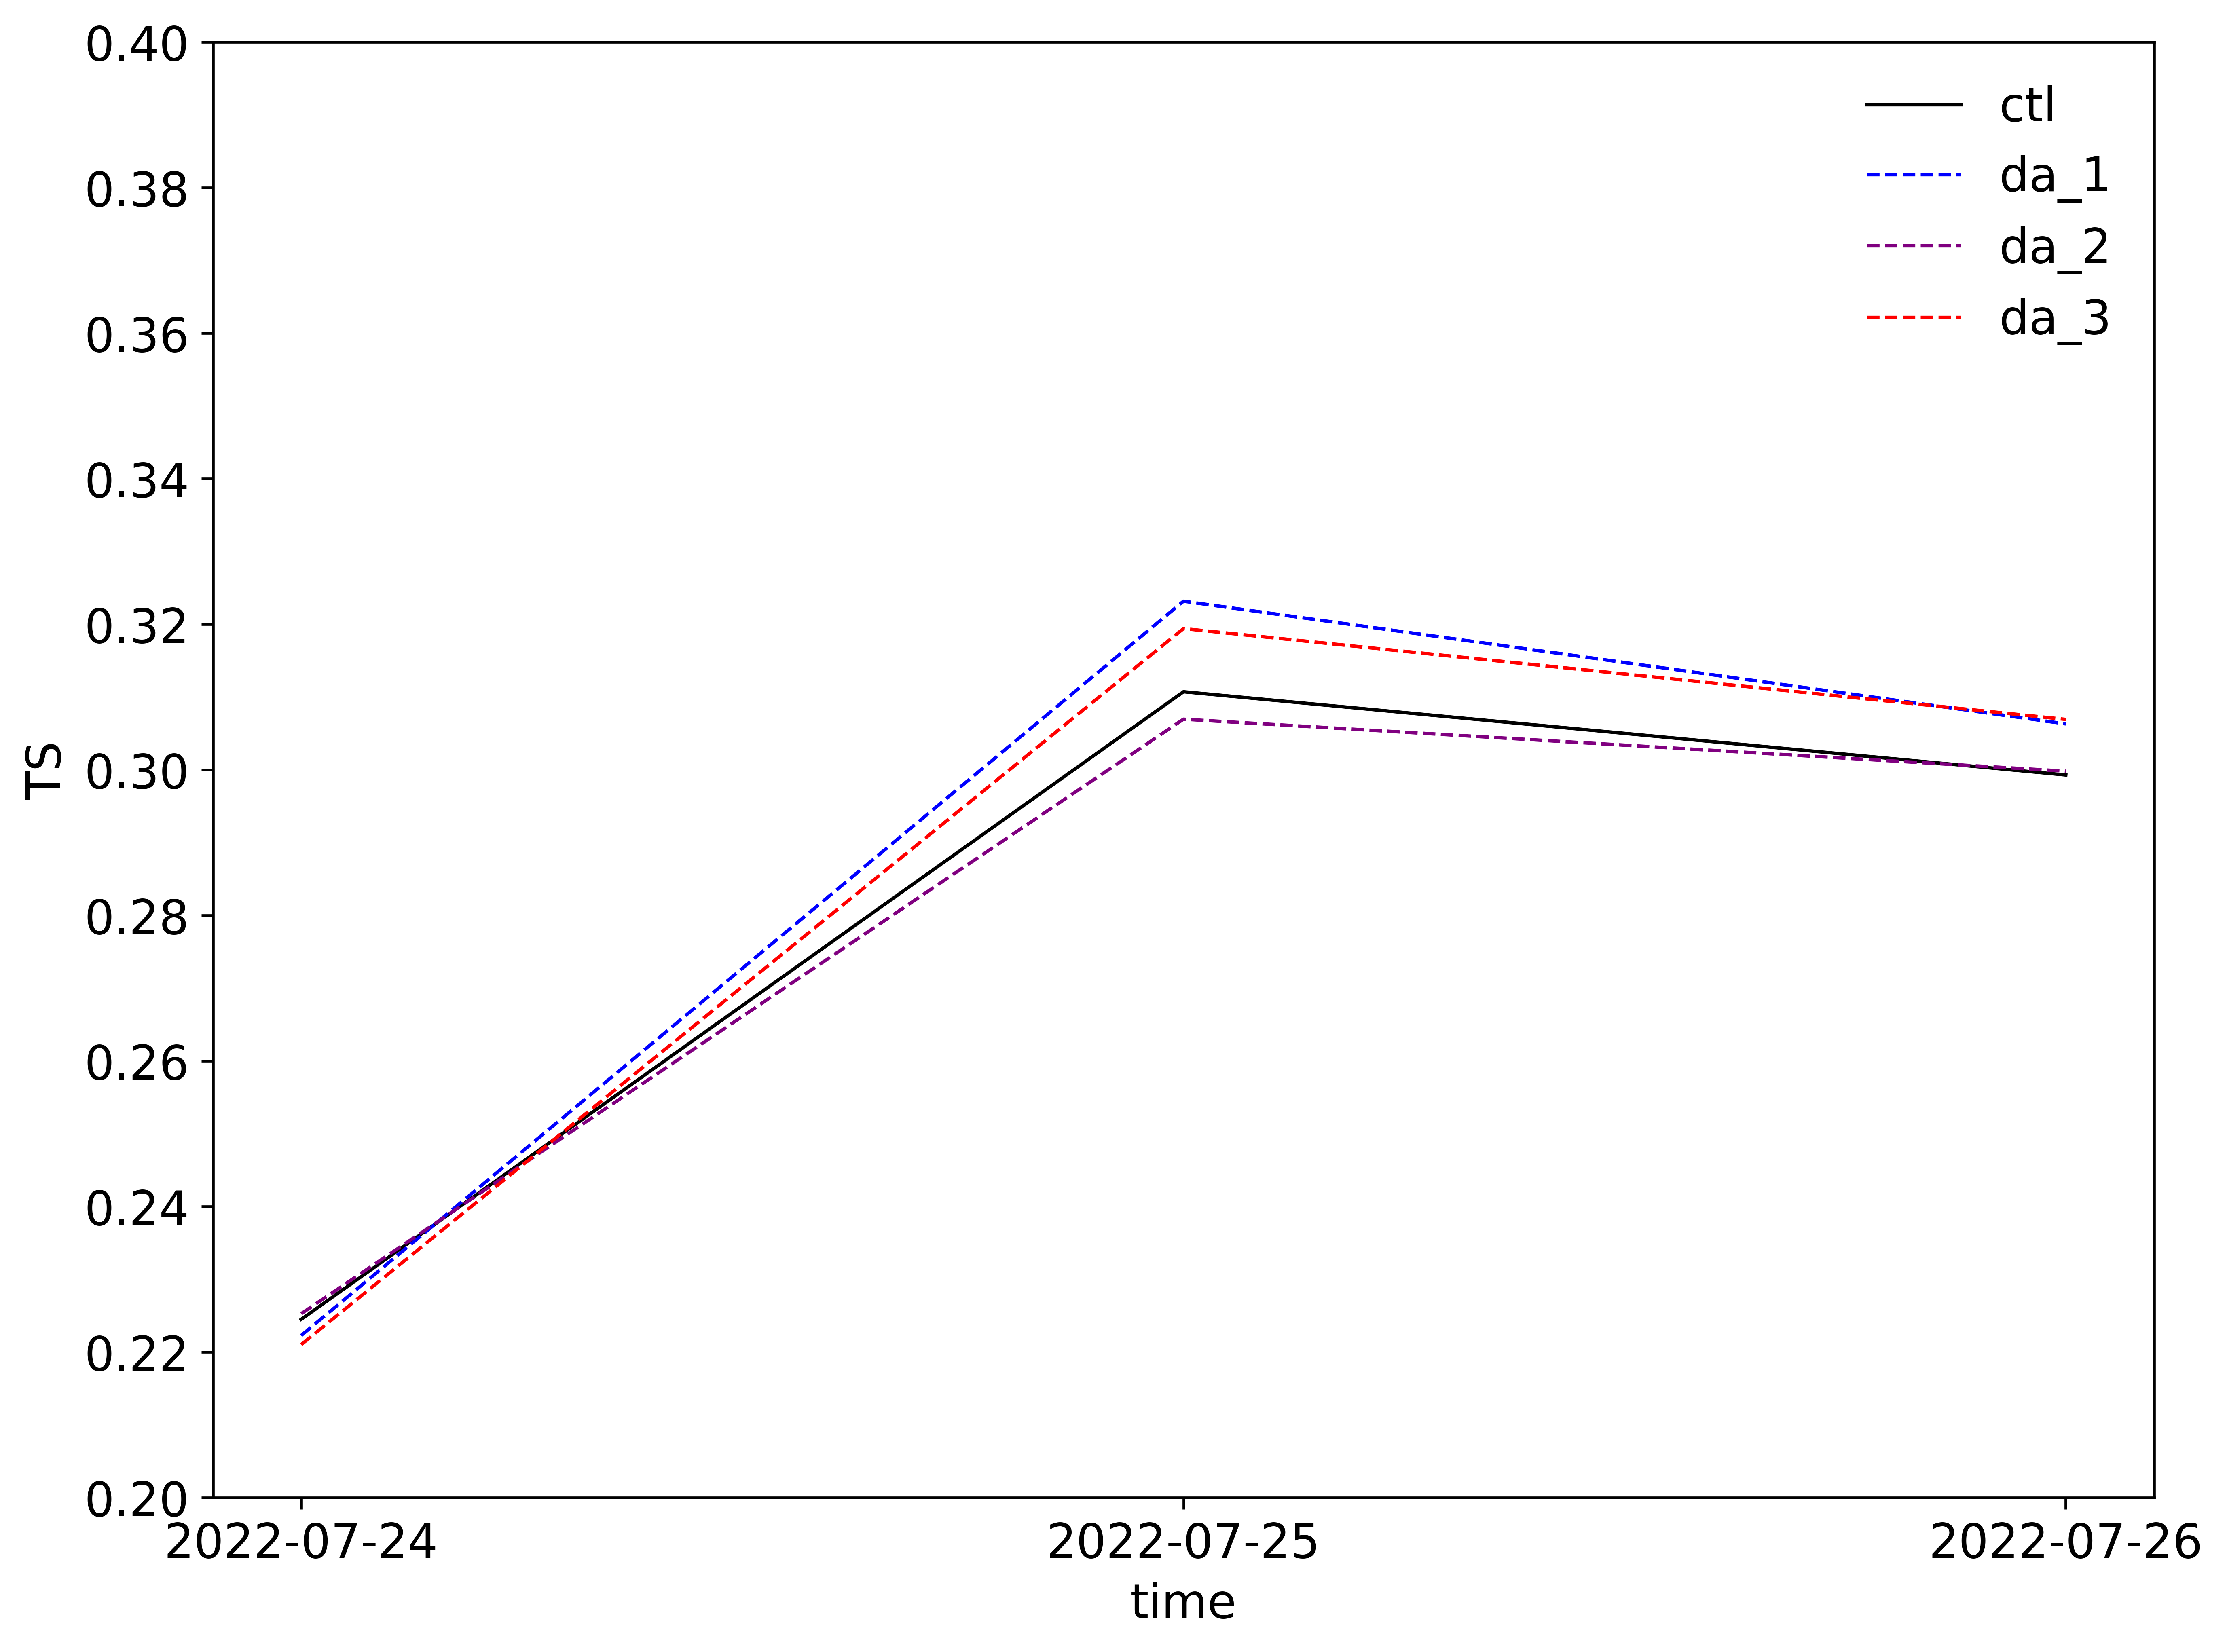

In [14]:
from cProfile import label
import matplotlib.pyplot as plt
import matplotlib as mpl
fig = plt.figure(figsize=[10,10],dpi=600,facecolor='white')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
ax = fig.add_axes([0.1,0.24,0.8,0.6])
ax.plot(np.arange(0,3), TS_ctl, color='black',label='ctl', lw=1, ls='-')
L = ['blue','purple','red']
for mem,cl in enumerate(L):
    print(f'敏感性试验{mem}',cl)
    ax.plot(np.arange(0,3), TS_wrfda[mem,], color=cl,label=f'da_{mem+1}', lw=1, ls='--')

plt.xticks(np.arange(0,3),["2022-07-24","2022-07-25","2022-07-26"])
ax.set_yticks(np.arange(0.,0.5,0.02))
ax.set_ylim([0.2,0.4])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylabel('TS',fontsize=14)
ax.set_xlabel('time',fontsize=14)
plt.legend(loc='upper right',fontsize=14,frameon=False)
fig.savefig("/mnt/d/work/sunhh/figure/no19-a_TS.png",dpi=600, bbox='tight')


In [13]:
TS_wrfda.shape

(3, 3)